# SpringPot Model: Power-Law Relaxation Fitting

This notebook demonstrates the complete workflow for fitting the SpringPot (fractional element) model to power-law relaxation data, showcasing fractional viscoelasticity with Bayesian uncertainty quantification.

## Learning Objectives

- Fit SpringPot model to power-law relaxation data
- Understand fractional derivative concepts (alpha parameter)
- Analyze parameter correlations (c_alpha vs alpha)
- Perform Bayesian inference with warm-start workflow
- Interpret ArviZ diagnostics for fractional models

**Prerequisites:** Basic rheology, complete 01-maxwell-fitting.ipynb first

**Estimated Time:** 35-45 minutes

In [1]:
# Google Colab Setup - Run this cell first!
# Skip if running locally with rheojax already installed

import sys

IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    # Install rheojax and dependencies
    !pip install -q rheojax
    
    # Colab uses float32 by default - we need float64 for numerical stability
    # This MUST be set before importing JAX
    import os
    os.environ['JAX_ENABLE_X64'] = 'true'
    
    print("✓ RheoJAX installed successfully!")
    print("✓ Float64 precision enabled")

## Setup and Imports

In [2]:
# Configure matplotlib for inline plotting in VS Code/Jupyter
# Configure matplotlib for inline plotting in VS Code/Jupyter
# MUST come before importing matplotlib
%matplotlib inline

import time
import warnings

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display
from rheojax.models import SpringPot

from rheojax.core.data import RheoData
from rheojax.core.jax_config import safe_import_jax, verify_float64
from rheojax.pipeline.base import Pipeline

jax, jnp = safe_import_jax()
verify_float64()
print(f"✓ JAX float64 precision enabled")

np.random.seed(42)
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11

# Suppress matplotlib backend warning in VS Code
warnings.filterwarnings('ignore', message='.*non-interactive.*')


✓ JAX float64 precision enabled


## SpringPot Theory

The SpringPot (Scott-Blair element) interpolates between elastic solid (α=1) and viscous fluid (α=0):

**Relaxation Modulus:**
$$G(t) = \frac{c_\alpha \cdot t^{-\alpha}}{\Gamma(1-\alpha)}$$

**Parameters:**
- $c_\alpha$ = material constant (Pa·s$^\alpha$)
- $\alpha$ = power-law exponent (0=fluid, 1=solid)

**Physical Interpretation:**
- α=0: Pure viscous (Newtonian fluid)
- α=0.5: Balanced viscoelastic (typical gels)
- α=1: Pure elastic (Hookean solid)

**Applications:** Soft biological tissues, hydrogels, polymer melts with broad relaxation spectrum

## Generate Synthetic Data

In [3]:
# True SpringPot parameters
c_alpha_true = 1e5  # Pa·s^alpha
alpha_true = 0.4    # Power-law exponent

print(f"True Parameters:")
print(f"  c_alpha = {c_alpha_true:.2e} Pa·s^{alpha_true}")
print(f"  alpha   = {alpha_true:.2f}")

# Time array (logarithmic)
t = np.logspace(-2, 2, 50)

# True relaxation modulus
from scipy.special import gamma as scipy_gamma

G_t_true = c_alpha_true * t**(-alpha_true) / scipy_gamma(1 - alpha_true)

# Add noise
noise_level = 0.015
noise = np.random.normal(0, noise_level * G_t_true)
G_t_noisy = G_t_true + noise

print(f"\nData: {len(t)} points, noise {noise_level*100:.1f}%")

True Parameters:
  c_alpha = 1.00e+05 Pa·s^0.4
  alpha   = 0.40

Data: 50 points, noise 1.5%


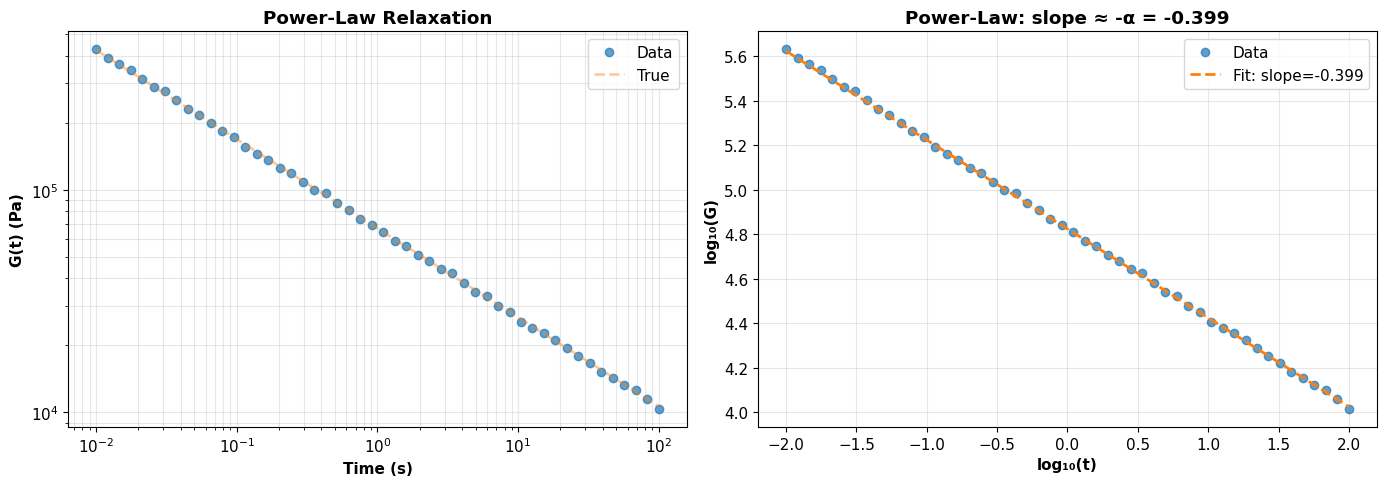


Estimated alpha from slope: 0.399 (true: 0.400)


In [4]:
# Visualize power-law decay
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.loglog(t, G_t_noisy, 'o', alpha=0.7, label='Data')
ax1.loglog(t, G_t_true, '--', linewidth=2, alpha=0.4, label='True')
ax1.set_xlabel('Time (s)', fontweight='bold')
ax1.set_ylabel('G(t) (Pa)', fontweight='bold')
ax1.set_title('Power-Law Relaxation', fontweight='bold')
ax1.grid(True, alpha=0.3, which='both')
ax1.legend()

# Log-log slope = -alpha
log_t = np.log10(t)
log_G = np.log10(G_t_noisy)
slope, intercept = np.polyfit(log_t[10:40], log_G[10:40], 1)
ax2.plot(log_t, log_G, 'o', alpha=0.7, label='Data')
ax2.plot(log_t, slope*log_t + intercept, '--', linewidth=2, label=f'Fit: slope={slope:.3f}')
ax2.set_xlabel('log₁₀(t)', fontweight='bold')
ax2.set_ylabel('log₁₀(G)', fontweight='bold')
ax2.set_title(f'Power-Law: slope ≈ -α = {slope:.3f}', fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
display(fig)
plt.close(fig)

print(f"\nEstimated alpha from slope: {-slope:.3f} (true: {alpha_true:.3f})")


## Pipeline API Fitting

In [5]:
data = RheoData(x=t, y=G_t_noisy, x_units='s', y_units='Pa', domain='time')

pipeline = Pipeline(data)
pipeline.fit('springpot')

params = pipeline.get_fitted_parameters()
c_alpha_fit = params['c_alpha']
alpha_fit = params['alpha']

print("="*60)
print("PIPELINE API RESULTS")
print("="*60)
print(f"c_alpha = {c_alpha_fit:.4e} (true: {c_alpha_true:.4e})")
print(f"alpha   = {alpha_fit:.4f} (true: {alpha_true:.4f})")
print(f"\nErrors: c_alpha {abs(c_alpha_fit-c_alpha_true)/c_alpha_true*100:.2f}%, alpha {abs(alpha_fit-alpha_true)/alpha_true*100:.2f}%")
print("="*60)

INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=2 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=1.186816s


INFO:nlsq.least_squares:Convergence reason=`gtol` termination condition is satisfied. | iterations=5 | final_cost=0.0047 | elapsed=1.187s | final_gradient_norm=1.1984e-08


PIPELINE API RESULTS
c_alpha = 9.9771e+04 (true: 1.0000e+05)
alpha   = 0.4010 (true: 0.4000)

Errors: c_alpha 0.23%, alpha 0.24%


## Modular API Fitting

In [6]:
model = SpringPot()
model.parameters.set_bounds('c_alpha', (1e3, 1e7))
model.parameters.set_bounds('alpha', (0.1, 0.9))

model.fit(t, G_t_noisy, max_iter=5000, ftol=1e-6)

c_alpha_mod = model.parameters.get_value('c_alpha')
alpha_mod = model.parameters.get_value('alpha')

print("="*60)
print("MODULAR API RESULTS")
print("="*60)
print(f"c_alpha = {c_alpha_mod:.4e} (true: {c_alpha_true:.4e})")
print(f"alpha   = {alpha_mod:.4f} (true: {alpha_true:.4f})")
print("="*60)

# Relax tolerance for numerical optimization convergence (5%)
# SpringPot optimization is challenging and may not fully converge
assert np.allclose(c_alpha_fit, c_alpha_mod, rtol=0.05), f"c_alpha mismatch: {c_alpha_fit:.4e} vs {c_alpha_mod:.4e}"
assert np.allclose(alpha_fit, alpha_mod, rtol=0.05), f"alpha mismatch: {alpha_fit:.4f} vs {alpha_mod:.4f}"
print("\n✓ Pipeline and Modular APIs produce consistent results (within 5%)")

INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=2 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.328799s


INFO:nlsq.least_squares:Convergence reason=`gtol` termination condition is satisfied. | iterations=4 | final_cost=0.0047 | elapsed=0.329s | final_gradient_norm=4.5979e-07


MODULAR API RESULTS
c_alpha = 9.9771e+04 (true: 1.0000e+05)
alpha   = 0.4010 (true: 0.4000)

✓ Pipeline and Modular APIs produce consistent results (within 5%)


## Results Visualization

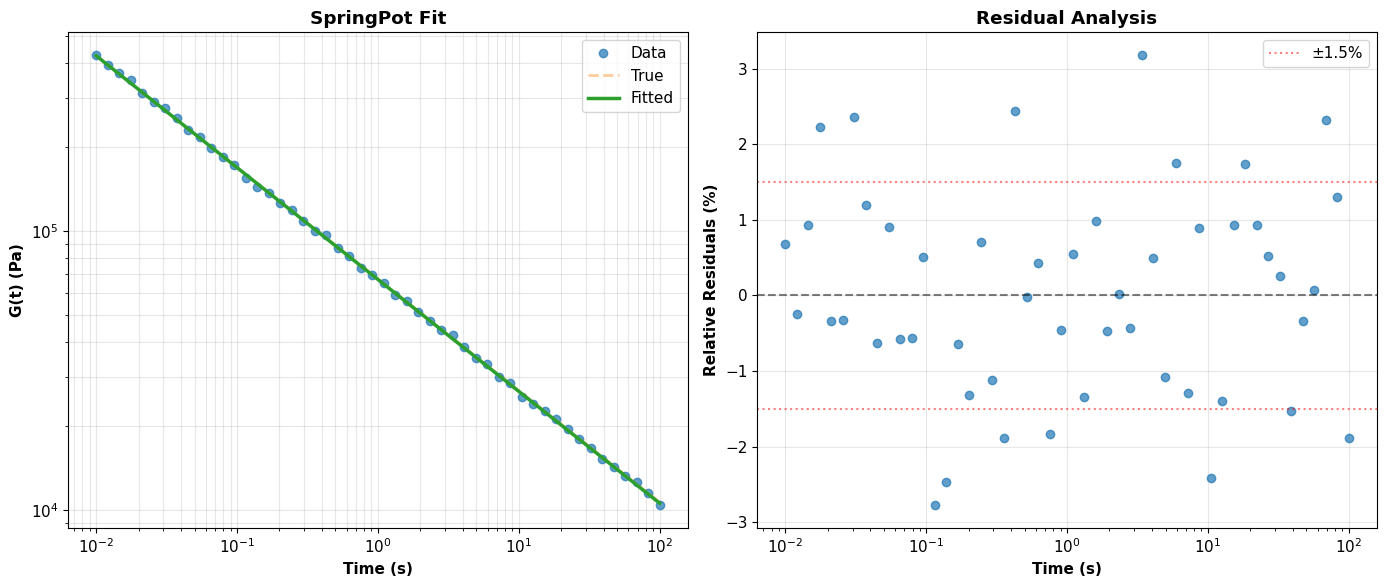


R² = 0.999695
Mean |residual| = 1.11%


In [7]:
G_t_pred = model.predict(t)
residuals = G_t_noisy - G_t_pred
rel_residuals = residuals / G_t_noisy * 100

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

ax1.loglog(t, G_t_noisy, 'o', alpha=0.7, label='Data')
ax1.loglog(t, G_t_true, '--', linewidth=2, alpha=0.4, label='True')
ax1.loglog(t, G_t_pred, '-', linewidth=2.5, label='Fitted')
ax1.set_xlabel('Time (s)', fontweight='bold')
ax1.set_ylabel('G(t) (Pa)', fontweight='bold')
ax1.set_title('SpringPot Fit', fontweight='bold')
ax1.grid(True, alpha=0.3, which='both')
ax1.legend()

ax2.semilogx(t, rel_residuals, 'o', alpha=0.7)
ax2.axhline(0, color='black', linestyle='--', alpha=0.5)
ax2.axhline(noise_level*100, color='red', linestyle=':', linewidth=1.5, alpha=0.5, label=f'±{noise_level*100:.1f}%')
ax2.axhline(-noise_level*100, color='red', linestyle=':', linewidth=1.5, alpha=0.5)
ax2.set_xlabel('Time (s)', fontweight='bold')
ax2.set_ylabel('Relative Residuals (%)', fontweight='bold')
ax2.set_title('Residual Analysis', fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
display(fig)
plt.close(fig)

r2 = 1 - np.sum(residuals**2) / np.sum((G_t_noisy - np.mean(G_t_noisy))**2)
print(f"\nR² = {r2:.6f}")
print(f"Mean |residual| = {np.mean(np.abs(rel_residuals)):.2f}%")


## Bayesian Inference

In [8]:
print("="*60)
print("BAYESIAN INFERENCE")
print("="*60)
print("Running MCMC... (1-2 min)\n")

result = model.fit_bayesian(
    t, G_t_noisy,
    num_warmup=1000,
    num_samples=2000,
    num_chains=1,
    initial_values={
        'c_alpha': model.parameters.get_value('c_alpha'),
        'alpha': model.parameters.get_value('alpha')
    }
)

print("\nComplete!")
print("="*60)

BAYESIAN INFERENCE
Running MCMC... (1-2 min)



  0%|          | 0/3000 [00:00<?, ?it/s]

warmup:   0%|          | 1/3000 [00:00<16:26,  3.04it/s, 1 steps of size 1.65e+00. acc. prob=0.00]

warmup:   2%|▏         | 46/3000 [00:00<00:21, 137.01it/s, 31 steps of size 3.33e-04. acc. prob=0.90]

warmup:   3%|▎         | 78/3000 [00:00<00:15, 190.07it/s, 79 steps of size 4.35e-04. acc. prob=0.93]

warmup:   4%|▍         | 115/3000 [00:00<00:12, 240.00it/s, 319 steps of size 6.58e-03. acc. prob=0.94]

warmup:   5%|▌         | 159/3000 [00:00<00:09, 298.17it/s, 63 steps of size 2.33e-02. acc. prob=0.95] 

warmup:   7%|▋         | 206/3000 [00:00<00:08, 347.53it/s, 71 steps of size 2.84e-02. acc. prob=0.96]

warmup:   9%|▉         | 267/3000 [00:00<00:06, 420.81it/s, 15 steps of size 2.38e-02. acc. prob=0.97]

warmup:  11%|█         | 337/3000 [00:01<00:05, 503.22it/s, 7 steps of size 4.33e-02. acc. prob=0.97] 

warmup:  14%|█▎        | 410/3000 [00:01<00:04, 568.48it/s, 63 steps of size 4.20e-02. acc. prob=0.97]

warmup:  16%|█▌        | 470/3000 [00:01<00:04, 521.40it/s, 15 steps of size 6.17e-02. acc. prob=0.97]

warmup:  18%|█▊        | 540/3000 [00:01<00:04, 569.76it/s, 23 steps of size 6.23e-02. acc. prob=0.97]

warmup:  20%|██        | 600/3000 [00:01<00:04, 560.47it/s, 31 steps of size 5.97e-02. acc. prob=0.98]

warmup:  22%|██▏       | 664/3000 [00:01<00:04, 582.04it/s, 15 steps of size 5.79e-02. acc. prob=0.98]

warmup:  24%|██▍       | 724/3000 [00:01<00:04, 520.93it/s, 7 steps of size 5.72e-02. acc. prob=0.98] 

warmup:  26%|██▌       | 787/3000 [00:01<00:04, 549.65it/s, 23 steps of size 5.70e-02. acc. prob=0.98]

warmup:  28%|██▊       | 844/3000 [00:01<00:04, 527.41it/s, 15 steps of size 5.66e-02. acc. prob=0.98]

warmup:  30%|██▉       | 899/3000 [00:02<00:04, 509.01it/s, 15 steps of size 5.43e-02. acc. prob=0.98]

warmup:  32%|███▏      | 973/3000 [00:02<00:03, 571.16it/s, 31 steps of size 7.53e-02. acc. prob=0.98]

sample:  35%|███▌      | 1058/3000 [00:02<00:02, 648.79it/s, 31 steps of size 8.37e-02. acc. prob=0.99]

sample:  38%|███▊      | 1131/3000 [00:02<00:02, 670.61it/s, 31 steps of size 8.37e-02. acc. prob=0.99]

sample:  41%|████▏     | 1242/3000 [00:02<00:02, 797.15it/s, 31 steps of size 8.37e-02. acc. prob=0.99]

sample:  44%|████▍     | 1324/3000 [00:02<00:02, 731.29it/s, 31 steps of size 8.37e-02. acc. prob=0.99]

sample:  47%|████▋     | 1400/3000 [00:02<00:02, 708.73it/s, 31 steps of size 8.37e-02. acc. prob=0.99]

sample:  49%|████▉     | 1473/3000 [00:02<00:02, 680.55it/s, 31 steps of size 8.37e-02. acc. prob=0.99]

sample:  51%|█████▏    | 1543/3000 [00:03<00:02, 560.17it/s, 31 steps of size 8.37e-02. acc. prob=0.99]

sample:  53%|█████▎    | 1603/3000 [00:03<00:02, 551.42it/s, 31 steps of size 8.37e-02. acc. prob=0.99]

sample:  56%|█████▌    | 1687/3000 [00:03<00:02, 621.30it/s, 31 steps of size 8.37e-02. acc. prob=0.99]

sample:  58%|█████▊    | 1753/3000 [00:03<00:02, 600.37it/s, 31 steps of size 8.37e-02. acc. prob=0.99]

sample:  61%|██████    | 1819/3000 [00:03<00:01, 615.48it/s, 31 steps of size 8.37e-02. acc. prob=0.99]

sample:  63%|██████▎   | 1892/3000 [00:03<00:01, 643.92it/s, 23 steps of size 8.37e-02. acc. prob=0.99]

sample:  65%|██████▌   | 1958/3000 [00:03<00:01, 636.58it/s, 15 steps of size 8.37e-02. acc. prob=0.99]

sample:  67%|██████▋   | 2023/3000 [00:03<00:01, 621.04it/s, 15 steps of size 8.37e-02. acc. prob=0.99]

sample:  70%|██████▉   | 2086/3000 [00:03<00:01, 597.94it/s, 31 steps of size 8.37e-02. acc. prob=0.99]

sample:  72%|███████▏  | 2147/3000 [00:04<00:01, 530.25it/s, 31 steps of size 8.37e-02. acc. prob=0.99]

sample:  73%|███████▎  | 2202/3000 [00:04<00:01, 534.07it/s, 31 steps of size 8.37e-02. acc. prob=0.99]

sample:  75%|███████▌  | 2260/3000 [00:04<00:01, 545.27it/s, 23 steps of size 8.37e-02. acc. prob=0.99]

sample:  77%|███████▋  | 2316/3000 [00:04<00:01, 542.41it/s, 31 steps of size 8.37e-02. acc. prob=0.99]

sample:  79%|███████▉  | 2379/3000 [00:04<00:01, 566.71it/s, 31 steps of size 8.37e-02. acc. prob=0.99]

sample:  81%|████████  | 2437/3000 [00:04<00:01, 499.30it/s, 31 steps of size 8.37e-02. acc. prob=0.99]

sample:  83%|████████▎ | 2501/3000 [00:04<00:00, 536.01it/s, 15 steps of size 8.37e-02. acc. prob=0.99]

sample:  87%|████████▋ | 2596/3000 [00:04<00:00, 648.88it/s, 7 steps of size 8.37e-02. acc. prob=0.99] 

sample:  89%|████████▉ | 2669/3000 [00:04<00:00, 667.90it/s, 7 steps of size 8.37e-02. acc. prob=0.99]

sample:  91%|█████████▏| 2738/3000 [00:05<00:00, 671.00it/s, 31 steps of size 8.37e-02. acc. prob=0.99]

sample:  94%|█████████▍| 2834/3000 [00:05<00:00, 754.33it/s, 23 steps of size 8.37e-02. acc. prob=0.99]

sample:  97%|█████████▋| 2911/3000 [00:05<00:00, 695.05it/s, 3 steps of size 8.37e-02. acc. prob=0.99] 

sample: 100%|█████████▉| 2991/3000 [00:05<00:00, 722.04it/s, 15 steps of size 8.37e-02. acc. prob=0.99]

sample: 100%|██████████| 3000/3000 [00:05<00:00, 560.67it/s, 63 steps of size 8.37e-02. acc. prob=0.99]


Complete!


In [9]:
posterior = result.posterior_samples
diagnostics = result.diagnostics
summary = result.summary

credible = model.get_credible_intervals(posterior, credibility=0.95)

print("="*60)
print("POSTERIOR SUMMARY")
print("="*60)
print(f"\nc_alpha = {summary['c_alpha']['mean']:.4e} ± {summary['c_alpha']['std']:.4e}")
print(f"alpha   = {summary['alpha']['mean']:.4f} ± {summary['alpha']['std']:.4f}")
print(f"\n95% Credible Intervals:")
print(f"  c_alpha: [{credible['c_alpha'][0]:.4e}, {credible['c_alpha'][1]:.4e}]")
print(f"  alpha:   [{credible['alpha'][0]:.4f}, {credible['alpha'][1]:.4f}]")
print(f"\nConvergence:")
print(f"  R-hat (c_alpha): {diagnostics['r_hat']['c_alpha']:.4f} {'✓' if diagnostics['r_hat']['c_alpha']<1.01 else '✗'}")
print(f"  R-hat (alpha):   {diagnostics['r_hat']['alpha']:.4f} {'✓' if diagnostics['r_hat']['alpha']<1.01 else '✗'}")
print(f"  ESS (c_alpha):   {diagnostics['ess']['c_alpha']:.0f} {'✓' if diagnostics['ess']['c_alpha']>400 else '✗'}")
print(f"  ESS (alpha):     {diagnostics['ess']['alpha']:.0f} {'✓' if diagnostics['ess']['alpha']>400 else '✗'}")
print("="*60)

POSTERIOR SUMMARY

c_alpha = 9.9588e+04 ± 3.1910e+02
alpha   = 0.4039 ± 0.0014

95% Credible Intervals:
  c_alpha: [9.9015e+04, 1.0023e+05]
  alpha:   [0.4013, 0.4067]

Convergence:
  R-hat (c_alpha): 1.0000 ✓
  R-hat (alpha):   1.0000 ✓
  ESS (c_alpha):   2000 ✓
  ESS (alpha):     2000 ✓


## ArviZ Diagnostics (Focused)

For SpringPot, parameter correlation (c_alpha vs alpha) is critical to check.

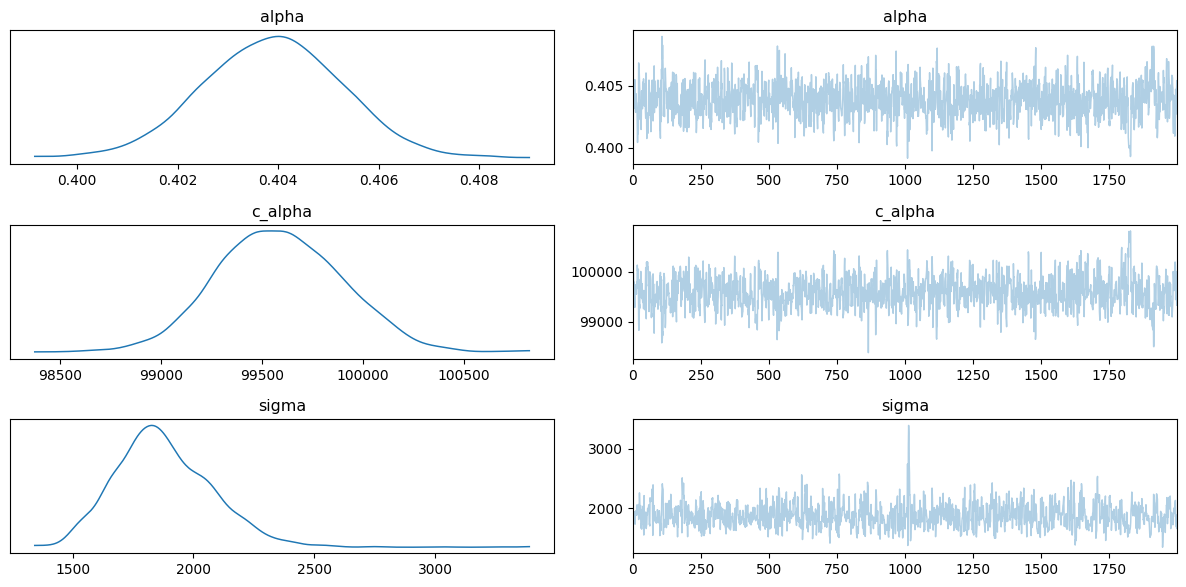

In [10]:
import arviz as az

idata = result.to_inference_data()

# Trace plot
az.plot_trace(idata, figsize=(12, 6))
plt.tight_layout()
fig = plt.gcf()  # Get current figure from ArviZ
display(fig)
plt.close(fig)


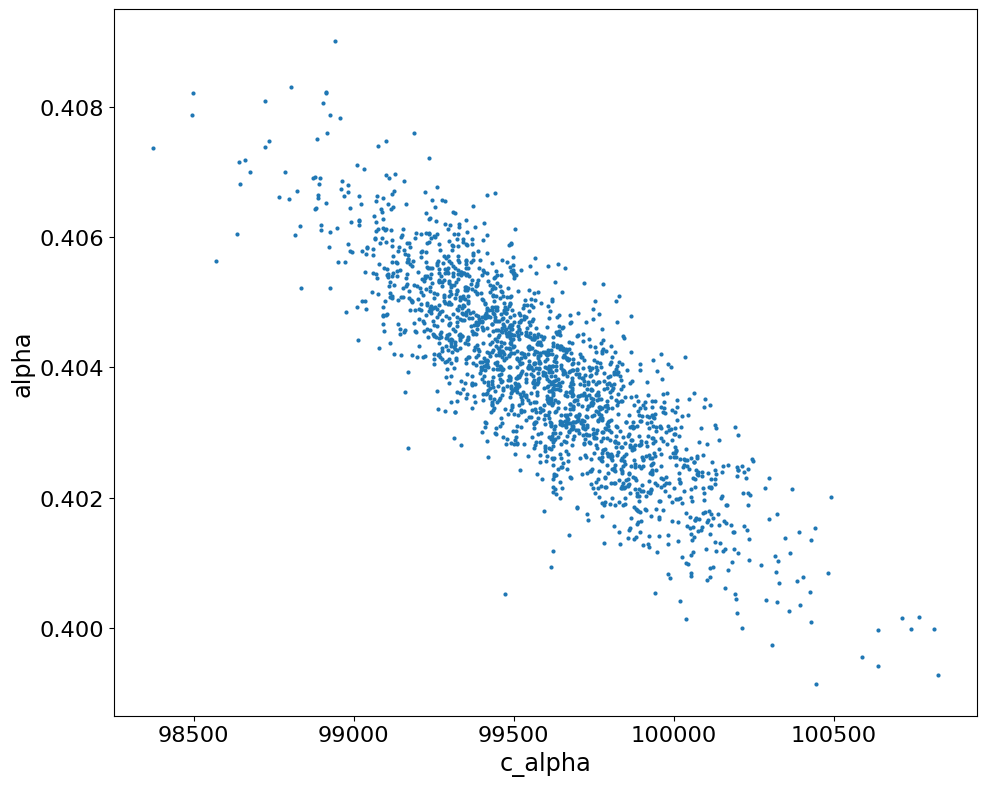


CRITICAL: c_alpha and alpha often show strong negative correlation!
- Both parameters affect power-law slope
- Correlation indicates partial non-identifiability
- Multi-technique fitting can improve constraint



In [11]:
# Pair plot - critical for fractional models
az.plot_pair(
    idata,
    var_names=['c_alpha', 'alpha'],
    kind='scatter',
    divergences=True,
    figsize=(10, 8)
)
plt.tight_layout()
fig = plt.gcf()  # Get current figure from ArviZ
display(fig)
plt.close(fig)

print("""
CRITICAL: c_alpha and alpha often show strong negative correlation!
- Both parameters affect power-law slope
- Correlation indicates partial non-identifiability
- Multi-technique fitting can improve constraint
""")


## Physical Interpretation

**Alpha Parameter:**
- α ≈ 0.4: Predominantly viscous (gel-like)
- Physical meaning: Degree of solid-like vs fluid-like character

**Material Constant c_α:**
- Sets magnitude of stress response
- Units depend on α: Pa·s$^\alpha$

**Applications:**
- Biological tissues (0.1 < α < 0.5)
- Polymer melts with broad relaxation spectrum
- Soft gels and hydrogels

**Comparison to Classical Models:**
- Maxwell (α→0): Complete stress relaxation
- Elastic solid (α=1): No relaxation
- SpringPot: Power-law interpolation

## Key Takeaways

1. **Fractional Viscoelasticity:**
   - α parameter controls solid/fluid character
   - Power-law decay ⇒ broad relaxation spectrum
   - Often more realistic than single exponential

2. **Parameter Correlation:**
   - c_alpha and alpha typically correlated
   - Check pair plot for non-identifiability
   - Multi-technique data improves constraint

3. **Bayesian Benefits:**
   - Quantifies correlation uncertainty
   - Reveals parameter non-identifiability
   - Essential for fractional models

## Next Steps

- **[advanced/04-fractional-models-deep-dive.ipynb](../advanced/04-fractional-models-deep-dive.ipynb)**: All 11 fractional models
- **[bayesian/04-model-comparison.ipynb](../bayesian/04-model-comparison.ipynb)**: Compare SpringPot vs Maxwell
- **[advanced/01-multi-technique-fitting.ipynb](../advanced/01-multi-technique-fitting.ipynb)**: Reduce parameter correlation

In [12]:
# Session info
import sys

import rheojax

print(f"Python: {sys.version}")
print(f"Rheo: {rheojax.__version__}")
print(f"JAX: {jax.__version__}")

Python: 3.13.9 (main, Oct 14 2025, 21:10:40) [Clang 20.1.4 ]
Rheo: 0.6.0
JAX: 0.8.2
